In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
import astropy as astr
from astropy.io import fits
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.visualization import hist
import glob
from scipy.ndimage import gaussian_filter
import sep
from scipy import stats
from photutils.aperture import CircularAperture
from photutils.datasets import make_100gaussians_image

path_bias = "Bicocca-Tele.data/ngc_6946_for_29th_Sep_2025/BIAS"
path_galaxy = "Bicocca-Tele.data/ngc_6946_for_29th_Sep_2025/LIGHT"
path_dark = "Bicocca-Tele.data/ngc_6946_for_29th_Sep_2025/DARK"
path_flat = "Bicocca-Tele.data/ngc_6946_for_29th_Sep_2025/FLAT"

In [2]:
with fits.open(path_bias +"/master_bias.fits") as hdu_bias:
  master_bias = hdu_bias[0].data
with fits.open(path_dark +"/master_dark_300.fits") as hdu_dark:
  master_dark = hdu_dark[0].data
with fits.open(path_galaxy +"/2025-09-29_18-29-26_sci_NGC6946_R_exp300.00_0000.fits") as hdu_galaxy: # 2025-09-29_18-12-19_sci_NGC6946_G_exp300.00_0000.fits
  image_data_galaxy = hdu_galaxy[0].data
with fits.open(path_flat +"/master_flat_R.fits") as hdu_flat:
  master_flat = hdu_flat[0].data
  
# Step 1: Clean the image
# cleaned_image = ((image_data_galaxy - master_bias - ((master_dark-master_bias)*t_exp_galaxy/t_exp_dark))/ master_flat)*0.25
cleaned_image = ((image_data_galaxy - master_bias - (master_dark-master_bias))/ master_flat)*0.25
# Step 2: Convert to physical flux 
calibration_constant_R = 5.45e-17   #  erg/s/cm² per electron
physical_image = cleaned_image * calibration_constant_R /1e-17


Mean:  961.0018556280678  Std Dev:  119.2142242854495


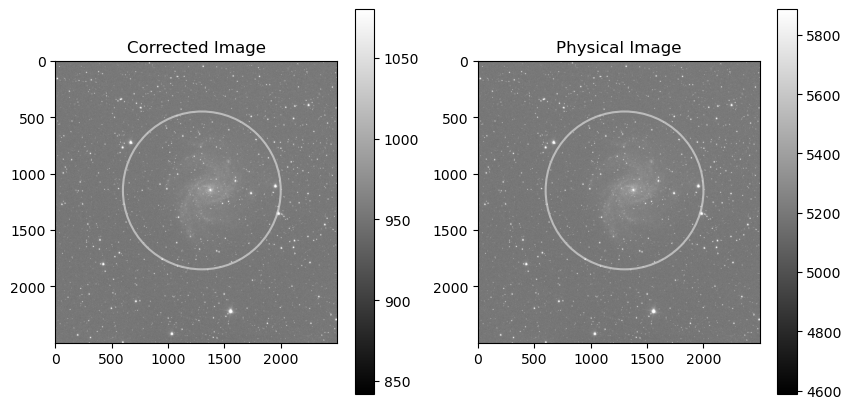

In [3]:

# position_x , position_y = 2382  ,1622   # The original target galaxy position in pixels coordinates from ds9


position_x, position_y = 1300 , 1150
position = (position_x,position_y)    
aperture = CircularAperture(position, r=700)

m, s = np.mean(cleaned_image), np.std(cleaned_image)
print("Mean: ", m, " Std Dev: ", s)
# show the image
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cleaned_image[500:3000, 1000:3500] ,cmap='grey', vmin = m-s, vmax= m+s ) #    ,clim=(750,1000) [1000:2500, 1500:3000] 
plt.colorbar()
aperture.plot(color='white', lw=1.5, alpha=0.5)
plt.title('Corrected Image')

plt.subplot(1,2,2)
m, s = np.mean(physical_image), np.std(physical_image)
plt.imshow(physical_image[500:3000, 1000:3500] ,cmap='grey', vmin = m-s, vmax= m+s )  # ,clim=(4.8e-14 ,5.3e-14) ,cmap='inferno' [1000:2500, 1500:3000], vmin = m_1-s_1, vmax= m_1+s_1
plt.colorbar()
aperture.plot(color='white', lw=1.5, alpha=0.5)
plt.title('Physical Image')
plt.show()

In [4]:
# !pip install sep # This must be downloaded on your device first.

## The first method: Substracting the median (Sky level constant)

!! Be carefull runing this code with number of bins higher than 10 as it would take very long time.

Mean before sub:  5237.460113172969  Std Dev:  649.7175223556998
Mean After sub:  20.451984438122317  Std Dev:  649.7175223556998


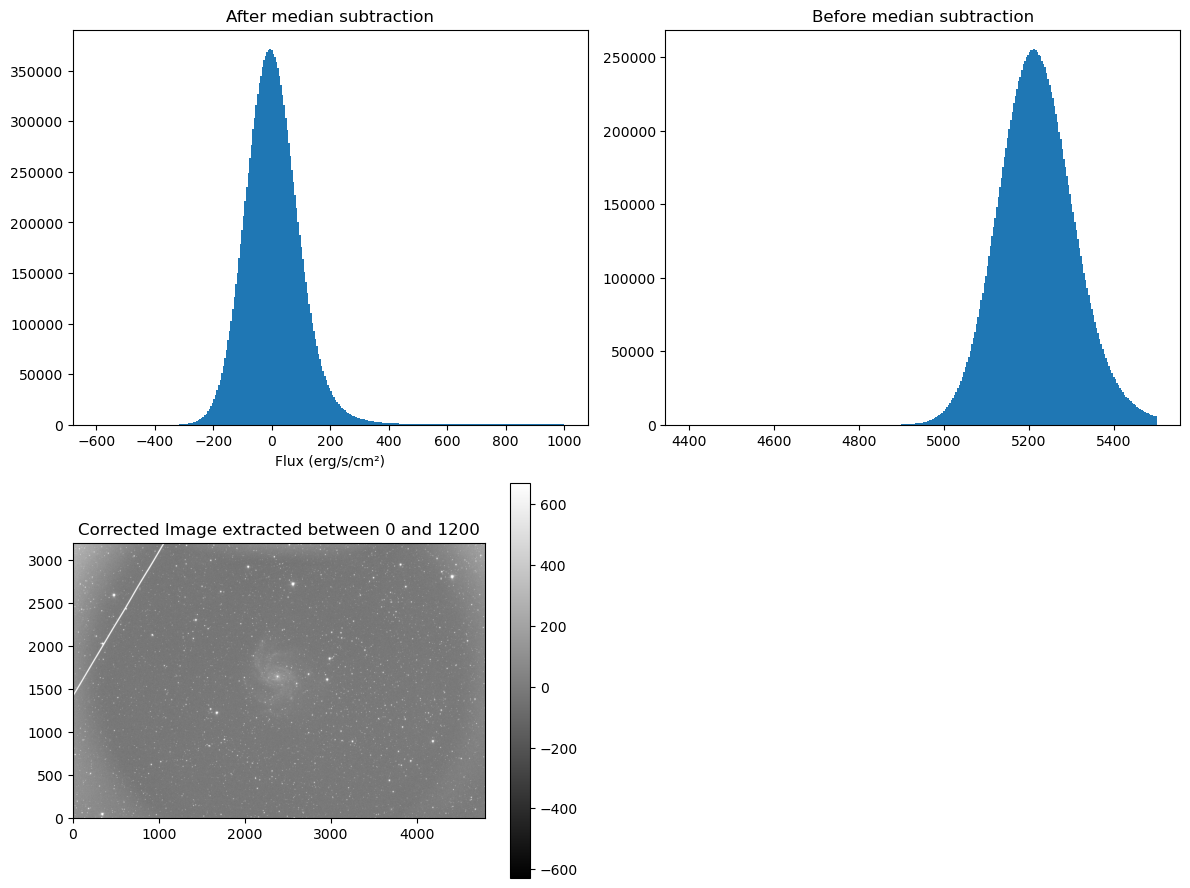

In [5]:
sky_level = np.median(physical_image)
physical_subtracted = physical_image - sky_level

bins = 300
mx = 1200
mn = 0
plt.figure(figsize=(12,9))
plt.subplot(2,2,1)
plt.hist(physical_subtracted.flatten(), bins= bins, range=(-600,1000))
plt.title('After median subtraction')
plt.xlabel('Flux (erg/s/cm²)')


plt.subplot(2,2,2)
m,s = np.mean(physical_image), np.std(physical_image)
print("Mean before sub: ", m, " Std Dev: ", s)
plt.hist(physical_image.flatten(), bins= bins, range=(4400,5500))
plt.title('Before median subtraction')

# physical_ranged = np.where((physical_subtracted > mn) & (physical_subtracted < mx), physical_subtracted,0)

plt.subplot(2,2,3)
m,s = np.mean(physical_subtracted), np.std(physical_subtracted)
print("Mean After sub: ", m, " Std Dev: ", s)
plt.imshow(physical_subtracted, cmap = 'grey' , vmin = m-s, vmax= m+s, origin = 'lower' )
plt.colorbar()
plt.title('Corrected Image extracted between '+ str(mn) + ' and ' + str(mx) )
plt.tight_layout()
plt.show()




## The second method: Extracting bright objects

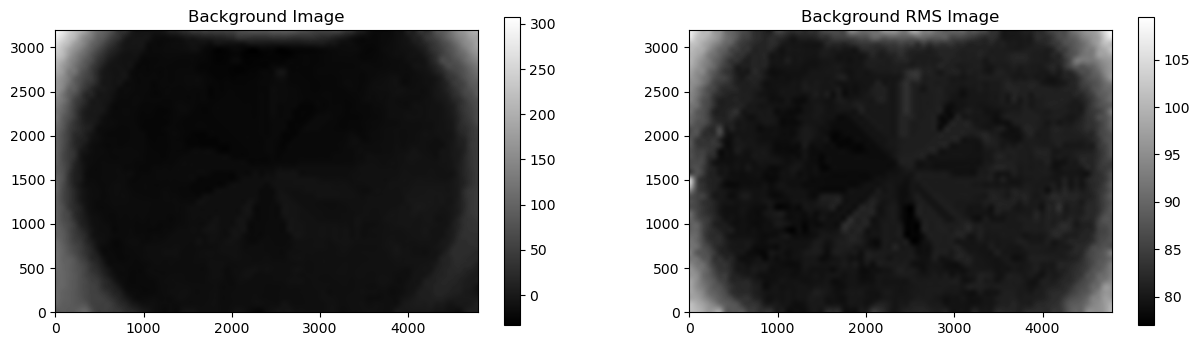

In [6]:
physical = physical_subtracted
mask = np.zeros(physical.shape, dtype=bool) # - It’s a selection tool: it excludes bright sources or unwanted regions so the background model is built only from “clean” sky pixels

# np.zeros(...) → makes an array filled with zeros.
# physical.shape → ensures it has the same dimensions as your image.
# dtype=bool → each element is a Boolean (False by default)

# mask[1000:2500, 1500:3000] = True             # Define a rectangular mask where True indicates the masked (ignored) regions to protect the galaxy from being extracted with the data.

# But we are going to use the aperture as we need to preserve a galaxy (we need a circular shape)
position_x , position_y = 2382  ,1622 
position = (position_x,position_y)    
aperture = CircularAperture(position, r=900)

mask_galaxy = aperture.to_mask(method='exact').to_image(physical.shape).astype(bool)
mask |= mask_galaxy # takes everything in mask and skips galaxy part
bkg = sep.Background(physical, mask = mask ) # sep.Background applies the mask to the original image. bw and bh are the box size for background estimation, fw and fh are the filter size for smoothing the background map.
# These can be controled in the sep.Background --> ,bw=64, bh=64, fw=3, fh=3
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms() # it shows the background noise level for each pixel. Although it is mostly uniform and ignored, there are small variations across the image.
 

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
# show the background
plt.imshow(bkg, interpolation='nearest', cmap='gray', origin='lower') # ,clim=(4.8e-14 ,5.3e-14)
plt.colorbar()
plt.title('Background Image')
plt.subplot(1,2,2)
# show the background Noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.title('Background RMS Image')
plt.show()

Number of detected objects:  654
Mean of the background subtracted image:  20.451984438122317   Standerd dev:  649.7175223556998


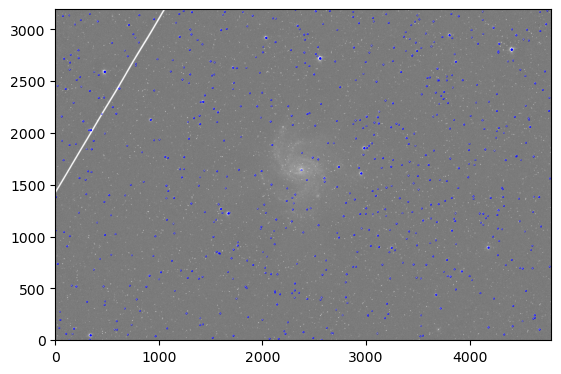

In [7]:
# subtract the background
bkg_filtered = physical - bkg.back()
# extract objects out of the background subtracted image
# Threshold specifies how many objects would be selected depending on brightness (Higher brightness thresh = fewer objects detected)
objects = sep.extract(bkg_filtered, thresh = 30 , err= bkg.globalrms) # In short: err=bkg.globalrms ensures object detection is scaled to the actual noise of your image, so faint stars aren’t confused with noise and bright ones aren’t overcounted
print("Number of detected objects: ", len(objects) )
# plot background-subtracted image
fig, ax = plt.subplots()
print("Mean of the background subtracted image: ", m, "  Standerd dev: ", s)
im = ax.imshow(bkg_filtered, cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower') # interpolation='nearest'

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width = 4*objects['a'][i],
                height = 4*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('blue')
    ax.add_artist(e)


Mean after sky subtraction:  16.691600365408522  Std Dev after sky subtraction:  410.7733956356206
Mean :  5237.460113172969  Std Dev :  649.7175223556998


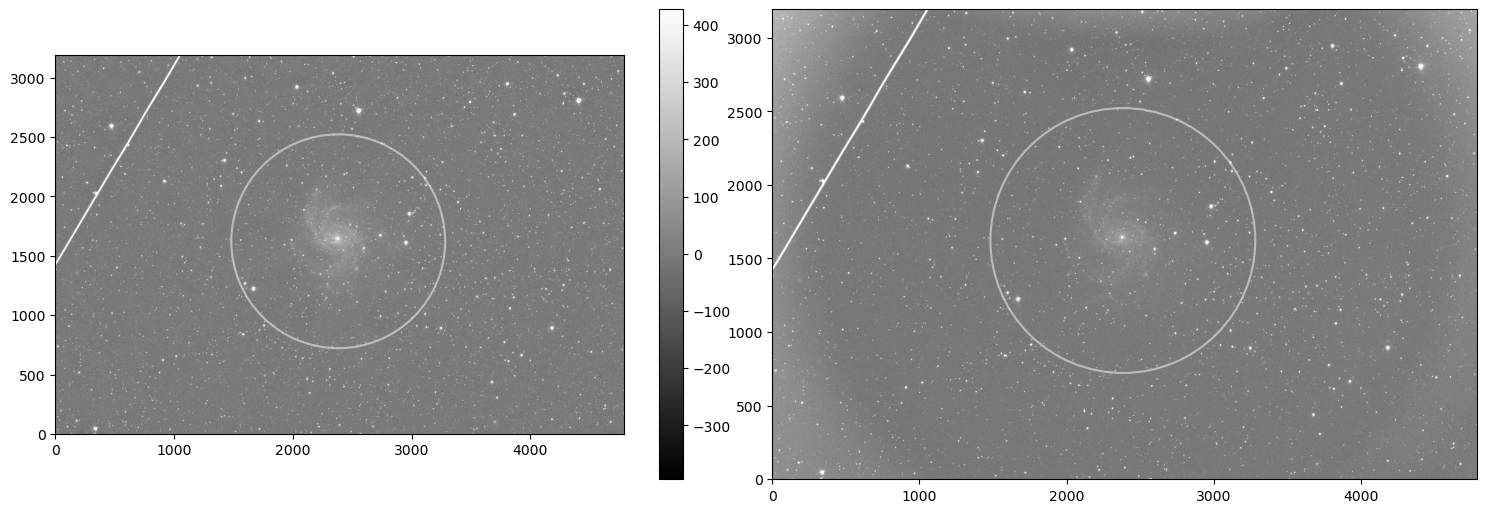

In [8]:
# remove mask_galaxy from the mask
mask &= ~mask_galaxy
# === Mask sources(objects) using ellipses ===
sep.mask_ellipse(
    mask,
    objects['x'], objects['y'],
    objects['a'], objects['b'],
    objects['theta'],
    r = 1  # scale factor for ellipse size
)
no_objects = np.where(mask, 0, bkg_filtered)

plt.figure(figsize= (15,5))
plt.subplot(1,2,1)
m, s = np.mean(no_objects), np.std(no_objects)
print("Mean after sky subtraction: ", m, " Std Dev after sky subtraction: ", s)
plt.imshow(no_objects , vmin= m-s, vmax= m+s , cmap='gray', origin='lower')
aperture.plot(color='white', lw=1.5, alpha=0.5)
plt.colorbar()
plt.tight_layout()


plt.subplot(1,2,2)
m, s = np.mean(physical_image), np.std(physical_image)
print("Mean : ", m, " Std Dev : ", s)
plt.imshow(physical_image , vmin = m-s, vmax = m+s, cmap='gray', origin='lower')
aperture.plot(color='white', lw=1.5, alpha=0.5)
plt.show()






In [9]:
# # It is only useful if you want to: measure star brightness, check detection quality, inspect whether objects are real vs noise, and validate your segmentation.

# # --- Background ---
# bkg = sep.Background(cleaned_image, bw=64, bh=64, fw=3, fh=3)
# data_sub = cleaned_image - bkg.back()

# # --- Extract objects ---
# thresh = 2.5
# objects = sep.extract(data_sub, thresh, err=bkg.globalrms)

# # --- Aperture photometry ---
# # flux → total light inside a circular aperture of radius 3 px
# # fluxerr → uncertainty on that measurement
# # flag → status flags (blends, saturation, etc.)
# flux, fluxerr, flag = sep.sum_circle(
#     data_sub,
#     objects["x"], objects["y"],
#     3.0,
#     err= bkg.rms(),
#     gain=1.0
# )

# # =============================
# # QUALITY CHECKS
# # =============================

# print("Total objects detected:", len(objects))

# # 1. Check if flux values are non-zero
# print("Non-zero flux fraction:",
#       np.mean(flux > 0))

# # 2. Check mean S/N
# sn = flux / fluxerr
# print("Median S/N:", np.median(sn))

# # 3. Count saturated or bad flags
# print("Objects with flags != 0:",
#       np.sum(flag != 0))

# # 4. Show brightest few objects (diagnostic)
# bright_idx = np.argsort(flux)[-5:]
# print("\nBrightest sources:")
# for i in bright_idx:
#     print(f" idx={i}, flux={flux[i]:.1f}, S/N={sn[i]:.1f}, flag={flag[i]}")

# # 5. Basic sanity: check background subtraction
# print("\nData_sub min/max:",
#       np.min(data_sub), np.max(data_sub))

# # Plot S/N ratios
# # sorted_idx = np.argsort(sn)
# # plt.plot(flux[sorted_idx] , sn[sorted_idx])
# # plt.title("Signal-to-Noise Ratios of Detected Objects")
# # plt.xlabel("Object Index")
# # plt.ylabel("S/N Ratio")
# # plt.show()


## What the previous code gives you:

If most flux values are zero → detection/background problem.

If median S/N < 3 → detections are mostly noise.

If flags ≠ 0 for many objects → bad data or saturated stars.

If data_sub min/max are extremely large or negative → wrong background subtraction.

If brightest objects have low S/N → image is too faint or background too strong.